In [2]:
"""
COMPLETE LLM-POWERED UNDERWRITING ASSISTANT
===============================================
Step 1: Train Approval Prediction Model
Step 2: Transform Dataset to Sentences (RAG)
Step 3: Embed Sentences
Step 4: Build FAISS Vector Store
Step 5: Deploy Interactive LLM Assistant
"""

'\nCOMPLETE LLM-POWERED UNDERWRITING ASSISTANT\n===============================================\nStep 1: Train Approval Prediction Model\nStep 2: Transform Dataset to Sentences (RAG)\nStep 3: Embed Sentences\nStep 4: Build FAISS Vector Store\nStep 5: Deploy Interactive LLM Assistant\n'

In [1]:
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & Embeddings
from sentence_transformers import SentenceTransformer
import faiss

In [3]:

# ============================================================================
# STEP 1: TRAIN APPROVAL PREDICTION MODEL
# ============================================================================

class UnderwritingModel:
    """
    Predicts insurance approval and provides risk assessment
    """
    
    def __init__(self):
        self.model = None
        self.feature_names = None
        self.model_metrics = {}
        
    def load_data(self):
        """Load the cleaned modeling-ready data"""
        df = pd.read_csv('../data/modeling_ready_data.csv')
        
        # Separate features and target
        X = df.drop(['OUTCOME', 'ID'], axis=1)
        y = df['OUTCOME']
        
        self.feature_names = X.columns.tolist()
        
        print(f"✓ Data loaded: {X.shape[0]} samples, {X.shape[1]} features")
        return X, y
    
    def train_model(self, X, y):
        """Train and evaluate multiple models"""
        print("\n" + "="*70)
        print("TRAINING APPROVAL PREDICTION MODEL")
        print("="*70)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"\nTrain set: {X_train.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        
        # Train multiple models
        models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
        }
        
        best_score = 0
        best_model_name = None
        
        for name, model in models.items():
            print(f"\n{'='*50}")
            print(f"Training: {name}")
            print('='*50)
            
            # Train
            model.fit(X_train, y_train)
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
            print(f"CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
            
            # Test predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Metrics
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            print(f"Test ROC-AUC: {roc_auc:.4f}")
            
            print(f"\nClassification Report:")
            print(classification_report(y_test, y_pred, target_names=['No Claim', 'Claim']))
            
            # Track best model
            if roc_auc > best_score:
                best_score = roc_auc
                best_model_name = name
                self.model = model
                self.model_metrics = {
                    'name': name,
                    'roc_auc': roc_auc,
                    'cv_scores': cv_scores.tolist(),
                    'X_test': X_test,
                    'y_test': y_test,
                    'y_pred': y_pred,
                    'y_pred_proba': y_pred_proba
                }
        
        print(f"\n{'='*70}")
        print(f"🏆 BEST MODEL: {best_model_name} (ROC-AUC: {best_score:.4f})")
        print('='*70)
        
        # Plot confusion matrix and ROC curve
        self._plot_model_performance()
        
        # Feature importance
        if hasattr(self.model, 'feature_importances_'):
            self._plot_feature_importance(X.columns)
        
        return self.model
    
    def _plot_model_performance(self):
        """Plot confusion matrix and ROC curve"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Confusion Matrix
        cm = confusion_matrix(self.model_metrics['y_test'], self.model_metrics['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                    xticklabels=['No Claim', 'Claim'],
                    yticklabels=['No Claim', 'Claim'])
        axes[0].set_title(f"Confusion Matrix - {self.model_metrics['name']}")
        axes[0].set_ylabel('True Label')
        axes[0].set_xlabel('Predicted Label')
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(self.model_metrics['y_test'], self.model_metrics['y_pred_proba'])
        axes[1].plot(fpr, tpr, label=f"ROC (AUC = {self.model_metrics['roc_auc']:.3f})", linewidth=2)
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('ROC Curve')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../outputs/model_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✓ Model performance plots saved")
    
    def _plot_feature_importance(self, feature_names):
        """Plot top 15 feature importances"""
        importances = self.model.feature_importances_
        indices = np.argsort(importances)[-15:]  # Top 15
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(indices)), importances[indices], color='steelblue')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title('Top 15 Most Important Features')
        plt.tight_layout()
        plt.savefig('../outputs/feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✓ Feature importance plot saved")
    
    def predict(self, X):
        """Predict approval and get probability"""
        pred = self.model.predict(X)
        proba = self.model.predict_proba(X)[:, 1]
        return pred, proba
    
    def save_model(self, filepath='../models/underwriting_model.pkl'):
        """Save trained model"""
        Path(filepath).parent.mkdir(parents=True, exist_ok=True)
        with open(filepath, 'wb') as f:
            pickle.dump({
                'model': self.model,
                'feature_names': self.feature_names,
                'metrics': self.model_metrics
            }, f)
        print(f"✓ Model saved to {filepath}")
    
    @staticmethod
    def load_model(filepath='../models/underwriting_model.pkl'):
        """Load trained model"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        
        model_obj = UnderwritingModel()
        model_obj.model = data['model']
        model_obj.feature_names = data['feature_names']
        model_obj.model_metrics = data['metrics']
        
        print(f"✓ Model loaded from {filepath}")
        return model_obj



[STEP 1/5] Training Approval Prediction Model...
✓ Data loaded: 10000 samples, 24 features

TRAINING APPROVAL PREDICTION MODEL

Train set: 8000 samples
Test set: 2000 samples

Training: Logistic Regression


/opt/anaconda3/envs/underwritegpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/underwritegpt/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stab

CV ROC-AUC: 0.9018 (+/- 0.0066)
Test ROC-AUC: 0.8857

Classification Report:
              precision    recall  f1-score   support

    No Claim       0.87      0.88      0.88      1373
       Claim       0.74      0.72      0.73       627

    accuracy                           0.83      2000
   macro avg       0.81      0.80      0.81      2000
weighted avg       0.83      0.83      0.83      2000


Training: Random Forest
CV ROC-AUC: 0.8959 (+/- 0.0072)
Test ROC-AUC: 0.8737

Classification Report:
              precision    recall  f1-score   support

    No Claim       0.85      0.88      0.87      1373
       Claim       0.72      0.67      0.69       627

    accuracy                           0.81      2000
   macro avg       0.78      0.77      0.78      2000
weighted avg       0.81      0.81      0.81      2000


Training: Gradient Boosting
CV ROC-AUC: 0.8988 (+/- 0.0082)
Test ROC-AUC: 0.8805

Classification Report:
              precision    recall  f1-score   support

    No

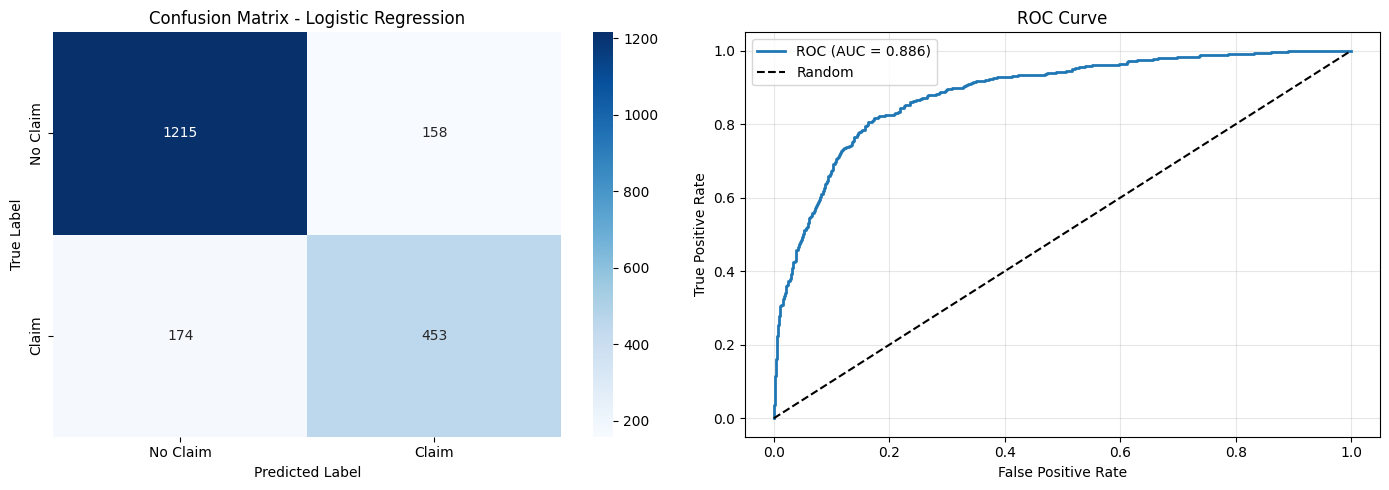

✓ Model performance plots saved
✓ Model saved to ../models/underwriting_model.pkl


In [4]:
# STEP 1: Train ML Model
print("\n[STEP 1/5] Training Approval Prediction Model...")
ml_model = UnderwritingModel()
X, y = ml_model.load_data()
ml_model.train_model(X, y)
ml_model.save_model()
    

In [5]:
# ============================================================================
# STEP 2: TRANSFORM DATASET TO SENTENCES (RAG)
# ============================================================================

class CustomerProfileTransformer:
    """
    Transforms structured customer data into natural language sentences for RAG
    """
    
    def __init__(self):
        self.customer_sentences = []
    
    def transform_to_sentences(self, df_path='../data/cleaned_insurance_data.csv'):
        """Convert each customer record to descriptive sentences"""
        print("\n" + "="*70)
        print("STEP 2: TRANSFORMING DATA TO SENTENCES")
        print("="*70)
        
        df = pd.read_csv(df_path)
        
        sentences = []
        metadata = []
        
        for idx, row in df.iterrows():
            # Create comprehensive customer profile
            profile = self._create_customer_profile(row)
            
            sentences.append(profile)
            metadata.append({
                'customer_id': row['ID'],
                'risk_category': row['RISK_CATEGORY'],
                'risk_score': row['RISK_SCORE'],
                'outcome': row['OUTCOME']
            })
            
            if (idx + 1) % 1000 == 0:
                print(f"  Processed {idx + 1}/{len(df)} customers...")
        
        print(f"\n✓ Transformed {len(sentences)} customer records to sentences")
        
        # Save
        self.customer_sentences = sentences
        self._save_sentences(sentences, metadata)
        
        return sentences, metadata
    
    def _create_customer_profile(self, row):
        """Create natural language profile for a customer"""
        
        # Basic demographics
        profile = f"Customer ID {row['ID']} is a {row['AGE']} year old {row['GENDER']} "
        profile += f"from the {row['RACE']} group with {row['DRIVING_EXPERIENCE']} of driving experience. "
        
        # Education and financial
        profile += f"They have {row['EDUCATION']} education and fall into the {row['INCOME']} income bracket. "
        profile += f"Their credit score is {row['CREDIT_SCORE']:.2f}. "
        
        # Vehicle information
        profile += f"They {'own' if row['VEHICLE_OWNERSHIP'] == 1 else 'do not own'} their vehicle, "
        profile += f"which is a {row['VEHICLE_TYPE']} manufactured {row['VEHICLE_YEAR']}. "
        profile += f"They drive approximately {row['ANNUAL_MILEAGE']:.0f} miles annually. "
        
        # Personal status
        marital = "married" if row['MARRIED'] == 1 else "not married"
        children = f"with {int(row['CHILDREN'])} {'child' if row['CHILDREN'] == 1 else 'children'}" if row['CHILDREN'] > 0 else "with no children"
        profile += f"This customer is {marital} {children}. "
        
        # Driving record
        if row['TOTAL_VIOLATIONS'] == 0:
            profile += "They have a clean driving record with no violations or accidents. "
        else:
            violations = []
            if row['SPEEDING_VIOLATIONS'] > 0:
                violations.append(f"{int(row['SPEEDING_VIOLATIONS'])} speeding violation(s)")
            if row['DUIS'] > 0:
                violations.append(f"{int(row['DUIS'])} DUI(s)")
            if row['PAST_ACCIDENTS'] > 0:
                violations.append(f"{int(row['PAST_ACCIDENTS'])} past accident(s)")
            
            profile += f"Their driving record includes: {', '.join(violations)}. "
        
        # Risk assessment
        profile += f"Risk Assessment: This customer is classified as {row['RISK_CATEGORY']} risk "
        profile += f"with a risk score of {row['RISK_SCORE']:.2f}. "
        
        # Key risk factors
        risk_factors = []
        if row['YOUNG_INEXPERIENCED'] == 1:
            risk_factors.append("young and inexperienced driver")
        if row['HAS_DUI'] == 1:
            risk_factors.append("DUI history")
        if row['LOW_CREDIT'] == 1:
            risk_factors.append("low credit score")
        if row['HIGH_MILEAGE'] == 1:
            risk_factors.append("high annual mileage")
        
        if risk_factors:
            profile += f"Key risk factors include: {', '.join(risk_factors)}. "
        else:
            profile += "No significant risk factors identified. "
        
        # Outcome
        profile += f"Historical outcome: This customer {'filed a claim' if row['OUTCOME'] == 1 else 'did not file a claim'}."
        
        return profile
    
    def _save_sentences(self, sentences, metadata):
        """Save sentences and metadata"""
        Path('../data/rag_data').mkdir(parents=True, exist_ok=True)
        
        # Save sentences
        with open('../data/rag_data/customer_sentences.txt', 'w') as f:
            for sentence in sentences:
                f.write(sentence + '\n\n')
        
        # Save metadata
        with open('../data/rag_data/customer_metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print("✓ Sentences and metadata saved")

In [6]:
# STEP 2: Transform to Sentences
print("\n[STEP 2/5] Transforming Data to Sentences...")
transformer = CustomerProfileTransformer()
sentences, metadata = transformer.transform_to_sentences()


[STEP 2/5] Transforming Data to Sentences...

STEP 2: TRANSFORMING DATA TO SENTENCES
  Processed 1000/10000 customers...
  Processed 2000/10000 customers...
  Processed 3000/10000 customers...
  Processed 4000/10000 customers...
  Processed 5000/10000 customers...
  Processed 6000/10000 customers...
  Processed 7000/10000 customers...
  Processed 8000/10000 customers...
  Processed 9000/10000 customers...
  Processed 10000/10000 customers...

✓ Transformed 10000 customer records to sentences
✓ Sentences and metadata saved


In [7]:
# ============================================================================
# STEP 3 & 4: EMBED SENTENCES AND BUILD FAISS INDEX
# ============================================================================

class UnderwritingRAG:
    """
    RAG system for underwriting using sentence embeddings and FAISS
    """
    
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        """Initialize with sentence transformer model"""
        print(f"\n{'='*70}")
        print("STEP 3 & 4: EMBEDDING & BUILDING FAISS INDEX")
        print('='*70)
        print(f"Loading embedding model: {model_name}...")
        
        self.embedding_model = SentenceTransformer(model_name)
        self.index = None
        self.sentences = []
        self.metadata = []
        self.dimension = 384  # MiniLM dimension
        
        print("✓ Embedding model loaded")
    
    def build_index(self, sentences, metadata):
        """Embed sentences and build FAISS index"""
        print(f"\nEmbedding {len(sentences)} customer profiles...")
        
        # Generate embeddings
        embeddings = self.embedding_model.encode(
            sentences, 
            show_progress_bar=True,
            batch_size=32
        )
        
        print(f"✓ Generated embeddings: {embeddings.shape}")
        
        # Build FAISS index
        print("\nBuilding FAISS index...")
        self.dimension = embeddings.shape[1]
        
        # Using IndexFlatL2 for exact search (good for <1M vectors)
        self.index = faiss.IndexFlatL2(self.dimension)
        self.index.add(embeddings.astype('float32'))
        
        self.sentences = sentences
        self.metadata = metadata
        
        print(f"✓ FAISS index built with {self.index.ntotal} vectors")
        
        return embeddings
    
    def search_similar_customers(self, query, top_k=5):
        """Search for similar customers based on query"""
        # Embed query
        query_embedding = self.embedding_model.encode([query])
        
        # Search FAISS
        distances, indices = self.index.search(query_embedding.astype('float32'), top_k)
        
        results = []
        for idx, dist in zip(indices[0], distances[0]):
            results.append({
                'customer_profile': self.sentences[idx],
                'metadata': self.metadata[idx],
                'similarity_score': float(1 / (1 + dist))  # Convert distance to similarity
            })
        
        return results
    
    def save_index(self, index_path='../models/faiss_index'):
        """Save FAISS index and metadata"""
        Path(index_path).mkdir(parents=True, exist_ok=True)
        
        # Save FAISS index
        faiss.write_index(self.index, f'{index_path}/customer.index')
        
        # Save sentences and metadata
        with open(f'{index_path}/sentences.pkl', 'wb') as f:
            pickle.dump(self.sentences, f)
        
        with open(f'{index_path}/metadata.pkl', 'wb') as f:
            pickle.dump(self.metadata, f)
        
        print(f"✓ FAISS index saved to {index_path}")
    
    @staticmethod
    def load_index(index_path='../models/faiss_index', model_name='all-MiniLM-L6-v2'):
        """Load FAISS index and metadata"""
        rag = UnderwritingRAG(model_name)
        
        # Load FAISS index
        rag.index = faiss.read_index(f'{index_path}/customer.index')
        
        # Load sentences and metadata
        with open(f'{index_path}/sentences.pkl', 'rb') as f:
            rag.sentences = pickle.load(f)
        
        with open(f'{index_path}/metadata.pkl', 'rb') as f:
            rag.metadata = pickle.load(f)
        
        print(f"✓ FAISS index loaded from {index_path}")
        return rag


In [9]:
# STEP 3 & 4: Embed and Build FAISS
print("\n[STEP 3-4/5] Embedding and Building FAISS Index...")
rag = UnderwritingRAG()
rag.build_index(sentences, metadata)
rag.save_index()


[STEP 3-4/5] Embedding and Building FAISS Index...

STEP 3 & 4: EMBEDDING & BUILDING FAISS INDEX
Loading embedding model: all-MiniLM-L6-v2...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 57ed9c73-106f-4d6e-a3f3-28d521cd4e5f)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


✓ Embedding model loaded

Embedding 10000 customer profiles...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

✓ Generated embeddings: (10000, 384)

Building FAISS index...
✓ FAISS index built with 10000 vectors
✓ FAISS index saved to ../models/faiss_index


In [10]:
# STEP 5: Initialize Assistant
print("\n[STEP 5/5] Initializing LLM Assistant...")
assistant = UnderwritingAssistant()



[STEP 5/5] Initializing LLM Assistant...


NameError: name 'UnderwritingAssistant' is not defined